<font color=#16A085>
    
# Python Analysis of the Dynamic FRET example data
Extract E and S information and make pretty plots.

</font>

Written by: Nadia M. Huisjes and Karl E. Duderstadt

In [1]:
# File paths and names
file_path_fiji = '/Applications/Fiji.app'  #Path to your Fiji application
saved_archive_name = '/Users/karlduderstadt4/git/mars-tutorials/Example_workflows/FRET/dynamic/holiday_junction_merged.yama' #Name of your saved archive

In [2]:
# Import packages
import imagej
import jpype
import jpype.imports

# Set the path to the local Fiji application if it does not exist yet
try:
    ij
except NameError:
    ij = imagej.init(file_path_fiji) 
    
# Import the other packages
import scyjava as sc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
from scyjava import jimport
File = jimport("java.io.File")
from de.mpg.biochem.mars.molecule import SingleMoleculeArchive
from scipy.stats import norm
from pylab import *
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

# Set up the connection to the archive
yamaFile = File(saved_archive_name) 
archive = SingleMoleculeArchive(yamaFile)

15:53:27.321 [SciJava-5b89e2f4-Thread-0] DEBUG loci.formats.ClassList - Could not find loci.formats.in.URLReader
java.lang.ClassNotFoundException: loci.formats.in.URLReader
	at java.net.URLClassLoader.findClass(URLClassLoader.java:382)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:419)
	at sun.misc.Launcher$AppClassLoader.loadClass(Launcher.java:352)
	at java.lang.ClassLoader.loadClass(ClassLoader.java:352)
	at java.lang.Class.forName0(Native Method)
	at java.lang.Class.forName(Class.java:264)
	at loci.formats.ClassList.parseLine(ClassList.java:196)
	at loci.formats.ClassList.parseFile(ClassList.java:258)
	at loci.formats.ClassList.<init>(ClassList.java:138)
	at loci.formats.ClassList.<init>(ClassList.java:122)
	at loci.formats.ImageReader.getDefaultReaderClasses(ImageReader.java:80)
	at io.scif.bf.BioFormatsFormat.cacheReaderClasses(BioFormatsFormat.java:538)
	at io.scif.bf.BioFormatsFormat.<init>(BioFormatsFormat.java:139)
	at sun.reflect.NativeConstructorAccessorImpl.newInsta

[WARNING] Not overwriting name 'Python':
	proposed = org.scijava.plugins.scripting.python.PythonScriptLanguage [file:/Applications/Fiji.app/jars/scripting-python-0.1.2-SNAPSHOT.jar
	existing = org.scijava.plugins.scripting.jython.JythonScriptLanguage [file:/Applications/Fiji.app/jars/scripting-jython-1.0.0.jar


#### Define utility functions

In [3]:
def create_df(meta_tag, mol_tag):
    '''Create a df from all molecules in the archive matching both the metadata and molecule tag'''
    #Create a list containing all molecules in the archive
    molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
    
    rowsList = []
    for molecule in molecules:
        if (archive.metadataHasTag(molecule.getMetadataUID(),meta_tag) & molecule.hasTag(mol_tag)):
            marsTable = archive.get(molecule.getUID()).getTable()
            for row in range(marsTable.getRowCount()):
                if math.isnan(marsTable.getValue('iiEapp', row)):
                    break
                rowDict = {}
                rowDict['iiEapp'] = marsTable.getValue('iiEapp', row)
                rowDict['iiSapp'] = marsTable.getValue('iiSapp', row)
                rowDict['iiiEapp'] = marsTable.getValue('iiiEapp', row)
                rowDict['iiiSapp'] = marsTable.getValue('iiiSapp', row)
                rowDict['E'] = marsTable.getValue('E', row)
                rowDict['S'] = marsTable.getValue('S', row)
                rowsList.append(rowDict)
                
    return pd.DataFrame(rowsList)

In [4]:
def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def twoGauss(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return A1*exp(-(x-mu1)**2/2/sigma1**2)+A2*exp(-(x-mu2)**2/2/sigma2**2)

def exponentialDecay(x, a, b):
    return a * np.exp(-b * x)

In [5]:
def fit_S(df, fit_col, bins, mu, sigma, A, show_model):
    ''''''
    y,x,_=hist(list(df[fit_col]),bins, alpha=0.3,label="data", range=(0, 1))
    x=(x[1:]+x[:-1])/2 #define x as the center of each bin
    expected=(mu, sigma, A)
    params,cov=curve_fit(gauss,x,y,expected)
    
    if (show_model == True):
        plot(x,gauss(x,*params),color='red',lw=3,label='model')
        legend()
    
    if (show_model == False):
        plt.close()
    
    return (params[0], params[1], params[2])

In [6]:
def fit_two_state_E(df, fit_col, bins, mu1, sigma1, A1, mu2, sigma2, A2, show_model):
    ''''''
    y,x,_=hist(list(df[fit_col]),bins, alpha=0.3,label="data", range=(0, 1))
    x=(x[1:]+x[:-1])/2 #define x as the center of each bin
    expected=(mu1, sigma1, A1, mu2, sigma2, A2)
    params,cov=curve_fit(twoGauss,x,y,expected)
    
    if (show_model == True):
        plot(x,twoGauss(x,*params),color='red',lw=3,label='model')
        legend()
    
    if (show_model == False):
        plt.close()
    
    #print('The fitted peak center lies at E =',params[0],'\n','Sigma:',params[1]) #prints the fit parameters and errors that were found
    return (params[0], params[1], params[2], params[3], params[4], params[5])

#### Import the E and S data from the archive

In [7]:
df_FRET = create_df("FRET", "FRET")
df_AO = create_df("AO", "Accepted")
df_DO = create_df("DO", "Accepted")

### E and S before corrections

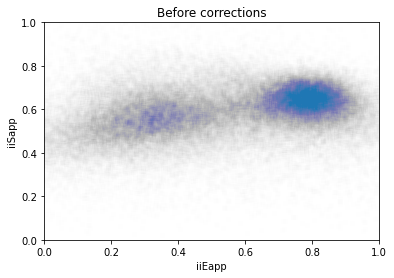

In [8]:
sns.scatterplot(data=df_FRET,x='iiEapp',y='iiSapp', alpha=0.002)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Before corrections")
plt.show()

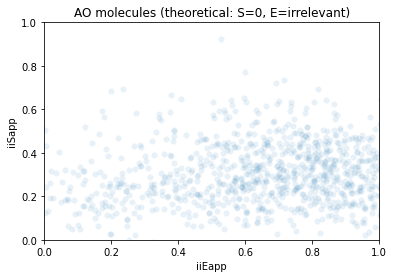

In [10]:
sns.scatterplot(data=df_AO,x='iiEapp',y='iiSapp', alpha=0.1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("AO molecules (theoretical: S=0, E=irrelevant)")
plt.show()

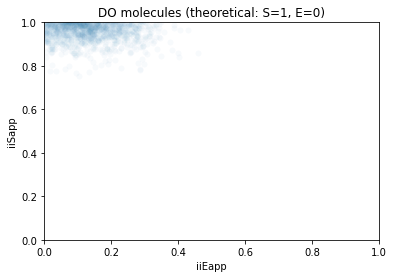

In [11]:
sns.scatterplot(data=df_DO,x='iiEapp',y='iiSapp', alpha=0.03)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("DO molecules (theoretical: S=1, E=0)")
plt.show()

### E and S after alpha/delta corrections

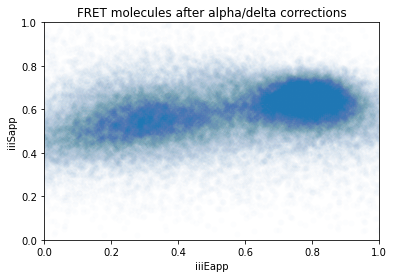

In [12]:
sns.scatterplot(data=df_FRET,x='iiiEapp',y='iiiSapp', alpha=0.01)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("FRET molecules after alpha/delta corrections")
plt.show()

### E and S after all corrections

Text(0.5, 1.0, 'FRET molecules, fully corrected')

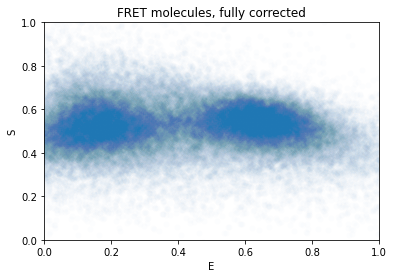

In [13]:
sns.scatterplot(data=df_FRET,x='E',y='S', alpha=0.01)
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("FRET molecules, fully corrected")

---

In [14]:
math.sqrt(df_FRET['S'].size)

279.4423017368702

0.15843892353432956 0.14092222470719817 373.2154047484964 0.630045893267947 0.1475329125807269 338.43980307820067
0.5190593852282488 0.1011669147027672 1001.1618047767477


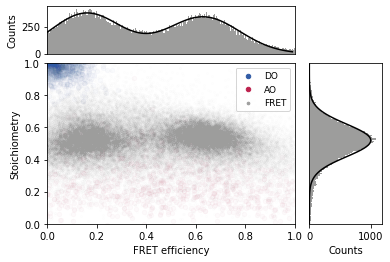

In [15]:
E_mu1, E_sigma1, E_A1, E_mu2, E_sigma2, E_A2 = fit_two_state_E(df_FRET, 'E', 280, 0.2, 0.1, 280, 0.8, 0.1, 280, False)
S_mu, S_sigma, S_A = fit_S(df_FRET, 'S', 280, 0.5, 1, 100, False)
x_list = list(arange(0,1,0.01))
y_list_S = gauss(x_list, S_mu, S_sigma, S_A)
y_list_E = twoGauss(x_list, E_mu1, E_sigma1, E_A1, E_mu2, E_sigma2, E_A2)
print(E_mu1, E_sigma1, E_A1, E_mu2, E_sigma2, E_A2)
print(S_mu, S_sigma, S_A)
fig = plt.figure()
gs = GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_y = fig.add_subplot(gs[0,0:3])
ax_hist_x = fig.add_subplot(gs[1:4, 3])

plt.rcParams.update({'font.size': 9})

ax_scatter.scatter(df_DO['E'],df_DO['S'],s=20,color='#315BA5',alpha=0.02, label='DO')
ax_scatter.scatter(df_AO['E'],df_AO['S'],s=20,color='#BD214D',alpha=0.02, label='AO')
ax_scatter.scatter(df_FRET['E'],df_FRET['S'],s=7,color='#9D9D9C',alpha=0.002,label='FRET')

ax_scatter.set_xlim(0,1)
ax_scatter.set_ylim(0,1)
ax_scatter.set_xlabel("FRET efficiency")
ax_scatter.set_ylabel("Stoichiometry")

ax_hist_y.hist(df_FRET['E'],bins=280,color='#9D9D9C',range=(0, 1))
ax_hist_y.plot(x_list,y_list_E,color='black')
ax_hist_y.xaxis.set_visible(False)
ax_hist_y.set_xlim(0,1)
ax_hist_y.set_ylabel("Counts")

ax_hist_x.hist(df_FRET['S'],color='#9D9D9C',orientation = 'horizontal',bins=280, range=(0, 1))
ax_hist_x.plot(y_list_S,x_list,color='black')
ax_hist_x.yaxis.set_visible(False)
ax_hist_x.set_ylim(0,1)
ax_hist_x.set_xlabel("Counts")


leg = ax_scatter.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)

plt.savefig("/Users/karlduderstadt4/Desktop/Final_ES_chart2.png",dpi=300)
plt.show()

y0 = 1039.12434
t = 0.36579


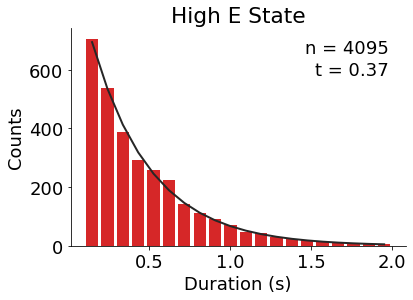

In [18]:
high_E_durations = []
molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
for molecule in molecules:
    if molecule.hasTag('FRET') and molecule.hasTag('Accepted'):
        segmentsTable = molecule.getSegmentsTable('532_Green_Time_(s)','E')
        for row in range(segmentsTable.getRowCount()):
            if segmentsTable.getValue("A", row) > 0.4:
                state = {}
                state['metaUID'] = molecule.getMetadataUID()
                state['value'] = segmentsTable.getValue("X2", row) - segmentsTable.getValue("X1", row)
                high_E_durations.append(state)
                                
high_E_durations_df = pd.DataFrame(high_E_durations)
    
y, bin_edges = np.histogram(high_E_durations_df['value'], bins=20, range=(0.1, 2))
x = (bin_edges[:-1] + bin_edges[1:]) / 2

popt, _ = curve_fit(exponentialDecay, x, y)
a, b = popt
print('y0 = %.5f\nt = %.5f' % (a, 1/b))

width = 0.8 * (x[1] - x[0])

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(1,1)
#axes.plot(x, y, lw=3)
axes.bar(x, y, align='center', color='#d62728', width=width)
axes.text(.95*axes.get_xlim()[-1], .95*axes.get_ylim()[-1], "n = "+str(high_E_durations_df['value'].size),
horizontalalignment='right',verticalalignment='top')
axes.text(.95*axes.get_xlim()[-1], .85*axes.get_ylim()[-1], f"t = {np.round(1/b,2)}",
horizontalalignment='right',verticalalignment='top')

y_line = exponentialDecay(x, a, b)
# create a line plot for the mapping function
axes.plot(x, y_line, '-', color='.15', lw=2)

axes.set_title("High E State")
axes.set_xlabel("Duration (s)")
axes.set_ylabel("Counts")
axes.tick_params(axis='x', labelsize=18)
axes.tick_params(axis='y', labelsize=18)
sns.despine()

plt.savefig("/Users/karlduderstadt4/Desktop/High_FRET_chart.png",dpi=300,bbox_inches='tight')

In [19]:
taoList = []
metaUIDs = high_E_durations_df['metaUID'].unique()
for metaUID in metaUIDs:
    y, bin_edges = np.histogram(high_E_durations_df[high_E_durations_df['metaUID'].eq(metaUID)]['value'], bins=20, range=(0.1, 2))
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    popt, _ = curve_fit(exponentialDecay, x, y)
    a, b = popt
    taoList.append(1/b)
    
np.std(taoList)

0.037333291726527995

y0 = 1205.99546
t1/2 = 0.30881


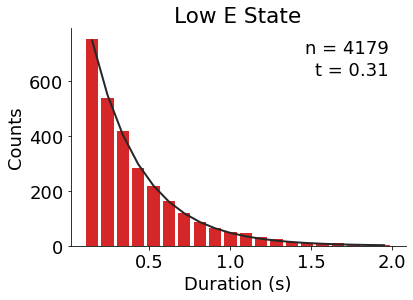

In [22]:
low_E_durations = []
molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
for molecule in molecules:
    if molecule.hasTag('FRET') and molecule.hasTag('Accepted'):
        segmentsTable = molecule.getSegmentsTable('532_Green_Time_(s)','E')
        for row in range(segmentsTable.getRowCount()):
            if segmentsTable.getValue("A", row) < 0.4:
                state = {}
                state['metaUID'] = molecule.getMetadataUID()
                state['value'] = segmentsTable.getValue("X2", row) - segmentsTable.getValue("X1", row)
                low_E_durations.append(state)
                                
low_E_durations_df = pd.DataFrame(low_E_durations)
    
y, bin_edges = np.histogram(low_E_durations_df['value'], bins=20, range=(0.1, 2))
x = (bin_edges[:-1] + bin_edges[1:]) / 2

popt, _ = curve_fit(exponentialDecay, x, y)
a, b = popt
print('y0 = %.5f\nt1/2 = %.5f' % (a, 1/b))

width = 0.8 * (x[1] - x[0])

fig, axes = plt.subplots(1,1)
axes.bar(x, y, align='center', color='#d62728', width=width)
axes.text(.95*axes.get_xlim()[-1], .95*axes.get_ylim()[-1], "n = "+str(low_E_durations_df['value'].size),
horizontalalignment='right',verticalalignment='top')
axes.text(.95*axes.get_xlim()[-1], .85*axes.get_ylim()[-1], f"t = {np.round(1/b,2)}",
horizontalalignment='right',verticalalignment='top')

y_line = exponentialDecay(x, a, b)
# create a line plot for the mapping function
axes.plot(x, y_line, '-', color='.15', lw=2)

axes.set_title("Low E State")
axes.set_xlabel("Duration (s)")
axes.set_ylabel("Counts")
axes.tick_params(axis='x', labelsize=18)
axes.tick_params(axis='y', labelsize=18)
sns.despine()

plt.savefig("/Users/karlduderstadt4/Desktop/Low_FRET_chart.png",dpi=300,bbox_inches='tight')

In [23]:
taoList = []
metaUIDs = low_E_durations_df['metaUID'].unique()
for metaUID in metaUIDs:
    y, bin_edges = np.histogram(low_E_durations_df[low_E_durations_df['metaUID'].eq(metaUID)]['value'], bins=20, range=(0.1, 2))
    x = (bin_edges[:-1] + bin_edges[1:]) / 2

    popt, _ = curve_fit(exponentialDecay, x, y)
    a, b = popt
    taoList.append(1/b)
    
np.std(taoList)

0.025265256203813712

In [24]:
example_molecules = ['6YWZbr6k44UHdj9uHWHnDS', '73jKvqXmCn9Pd7wtcicXkG','aXEaurcW7KYh8H41h84aFF', 
                     'bjLEGrWXkfiWHZckHCkRiY', 'cJf5W6DNSUbAhJGb17J3Xz','dJqGcJ11agGTkAiKQPmiSV', 
                     'fPYPevZkM6giij2S2jAm8X', 'gBZdX7V9dj78Fo6Yc1am1t','guKLc61amP4qq3dqi8VuVw', 
                      'uGK2y7rgkK6joBbgnveZHn']

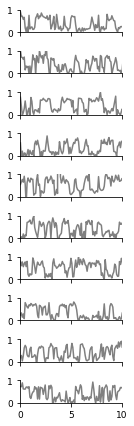

In [26]:
# HJ switching examples
rows = 10
cols = 1

fig,axes=plt.subplots(rows,cols,figsize=(2,6),sharex=True, sharey=True)

for i,uid in enumerate(example_molecules):
    table = sc._table_to_pandas(archive.get(uid).getTable())
    sns.lineplot(x='532_Green_Time_(s)', y='E',data=table, ax=axes[i],color='gray')
        
for ax in axes:
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    
plt.rcParams.update({'font.size': 9})

plt.xlim(0,10)
plt.ylim([0,1])
sns.despine()

fig.tight_layout()

plt.savefig("/Users/karlduderstadt4/Desktop/example_molecules.svg",transparent=True)